
# Maximal Representative Subsampling


In [1]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from scipy import stats

import pandas as pd
import pandas_profiling
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide = 'ignore')
import random

path = Path(os.getcwd()).parent

<div class="alert alert- block alert-warning"> <b>Done:</b> 

- CV auf Trainingsdaten. "weniger komplex mit jeder weiteren Iteration"
- Warum sind so viele arbeitslos?
- Donnerstag 11.07. 17 Uhr.

</div>

### Plots

In [2]:
def plot_results(score, n, title):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    dropped = [n[0]-i for i in n]
    plots(dropped, [k[0] for k in ks], "KS")
    plots(dropped, [k[1] for k in ks], "KS (p-value)")
    plots(dropped, auc, "AUC")
    plt.legend(loc='lower left')
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()

def plots(x, y, name):
    plt.plot(x, y, label=name)
    if(name == "AUC"):
        plt.plot(x, len(x)*[0.5], linestyle='--')
    plt.xlabel("removed instances")
    plt.grid()

## MRS ALGORITHM

In [8]:
def temp_sample(softmax, temperature, drop):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

def MRS(data, columns, temperature, n_drop = 20, limit = 50, 
        ensemble_size = 200, test_size = 0.5, baseline = False):
    
    data_base = data.copy(deep=True)
    
    global score
    global n
    global imp

    data = data_base.copy(deep=True)

    while (min(len(data[data.label == 1]), 
               len(data[data.label == 0])) > limit):    
        
        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)
        
        data = pd.concat([nonrep, rep], sort=True)

        train, test = train_test_split(data, test_size=test_size)
        test = pd.DataFrame(test)

        preds = [0]*len(test)
        for _ in range(ensemble_size):

            bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
            
            dt = DecisionTreeClassifier()
            depths = np.array([1, 2, 3, 4])
            grid = GridSearchCV(cv=3, estimator=dt, iid=True,
                                param_grid=dict(max_depth=depths))
            grid.fit(bootstrap[columns], bootstrap.label)
            
            dt = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth)
            dt.fit(bootstrap[columns], bootstrap.label)
            
            imp = [i + f for i,f in zip(imp, dt.feature_importances_)]
            
            prob = [p[1] for p in dt.predict_proba(test[columns])]
            preds = [pre + pro for pre,pro in zip(preds, prob)]
            
        preds = [f/ensemble_size for f in preds]
        
        score.append((test.label, preds))
        n.append(len(data.index))

        print(len(data.index), end=', ')

        if baseline == True: 
            preds = [random.random() for _ in preds]

        test['removed'] = temp_sample(preds, temperature, n_drop)
        test = test[test.removed == 0]
        test.drop('removed', axis=1, inplace=True) #inplace?

        data = pd.concat([train, test], sort=True)
    
    #return data

- kein pruning stattdessen min anzahl an instanzen.
- bootstrap sampling verändern: k=len(gbs) viele aus beiden datensätzen einzeln 
- nur gbs entfernen.

--> nächster Termin: 31.07. Uhr 17Uhr. 

### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [4]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country']
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 ;; >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = pd.concat([df_low.head(15890).copy(deep=True),
                 df_high.head(5000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(4000).copy(deep=True),
                    df_high.tail(6000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

us = pd.concat([nonrep, rep], sort=True)

us_columns = list(us.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in us_columns:
        us_columns.remove(m)

us.head()

Rep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  >50K     6000
 <=50K    4000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
30257,<=50K,23,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,239375.0,1
34094,<=50K,40,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,222504.0,1
15773,<=50K,63,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,156799.0,1
40503,<=50K,52,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,30908.0,1
34198,<=50K,23,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,187447.0,1


In [9]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))

allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)

allensbach_columns = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstätigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

#profile = allensbach.profile_report(title='Allensbach Profiling Report')
#profile.to_file("Allensbach data profiling.html")
allensbach.head()

,Alter,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,Berufsgruppe,Erwerbstätigkeit,Geschlecht,IE_ext1,IE_ext2,IE_int1,IE_int2,Id,Optimismus,Pessimismus,Schulabschluss,label,woechentlicheArbeitszeit
0,48.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0,4.0,3.0,3.0,GBS+00027,3.0,4.0,3.0,1,4.0
1,68.0,5.0,1.0,5.0,1.0,5.0,1.0,8.0,1.0,2.0,2.0,1.0,5.0,5.0,GBS+00032,7.0,1.0,5.0,1,1.0
2,56.0,4.0,4.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,3.0,3.0,3.0,3.0,GBS+00071,4.0,4.0,3.0,1,3.0
3,55.0,4.0,2.0,4.0,3.0,4.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00084,5.0,2.0,4.0,1,3.0
4,60.0,5.0,2.0,5.0,2.0,5.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00092,6.0,2.0,5.0,1,5.0


In [10]:
score = []
n = []
imp = [0]*len(allensbach_columns)

MRS(data=allensbach, columns=allensbach_columns, temperature=0.2, n_drop=1, limit=20)

1632, 1631, 1630, 1629, 1628, 1627, 1626, 1625, 1624, 1623, 1622, 1621, 1620, 1619, 1618, 1617, 1616, 1615, 1614, 1613, 1612, 1611, 1610, 1609, 1608, 1607, 1606, 1605, 1604, 1603, 1602, 1601, 1600, 1599, 1598, 1597, 1596, 1595, 1594, 1593, 1592, 1591, 1590, 1589, 1588, 1587, 1586, 1585, 1584, 1583, 1582, 1581, 1580, 1579, 1578, 1577, 1576, 1575, 1574, 1573, 1572, 1571, 1570, 1569, 1568, 1567, 1566, 1565, 1564, 1563, 1562, 1561, 1560, 1559, 1558, 1557, 1556, 1555, 1554, 1553, 1552, 1551, 1550, 1549, 1548, 1547, 1546, 1545, 1544, 1543, 1542, 1541, 1540, 1539, 1538, 1537, 1536, 1535, 1534, 1533, 1532, 1531, 1530, 1529, 1528, 1527, 1526, 1525, 1524, 1523, 1522, 1521, 1520, 1519, 1518, 1517, 1516, 1515, 1514, 1513, 1512, 1511, 1510, 1509, 1508, 1507, 1506, 1505, 1504, 1503, 1502, 1501, 1500, 1499, 1498, 1497, 1496, 1495, 1494, 1493, 1492, 1491, 1490, 1489, 1488, 1487, 1486, 1485, 1484, 1483, 1482, 1481, 1480, 1479, 1478, 1477, 1476, 1475, 1474, 1473, 1472, 1471, 1470, 1469, 1468, 1467, 1466

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


806, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


805, 804, 803, 802, 801, 800, 799, 798, 797, 796, 795, 794, 793, 792, 791, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


790, 789, 788, 787, 786, 785, 784, 783, 782, 781, 780, 779, 778, 777, 776, 775, 774, 773, 772, 771, 770, 769, 768, 767, 766, 765, 764, 763, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


762, 761, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


760, 759, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


758, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


757, 756, 755, 754, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


753, 752, 751, 750, 749, 748, 747, 746, 745, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


744, 743, 742, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


741, 740, 739, 738, 737, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


736, 735, 734, 733, 732, 731, 730, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-pack

729, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


728, 727, 726, 725, 724, 723, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


722, 721, 720, 719, 718, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


717, 716, 715, 714, 713, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-pack

712, 711, 710, 709, 

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


708, 707, 706, 705, 704, 703, 

In [5]:
score = []
n = []
imp = [0]*len(us_columns)

MRS(data=us, columns=us_columns, temperature=0.2, n_drop=200, limit=600)

30890, 30695, 30503, 30311, 30116, 29921, 29724, 29535, 29341, 29151, 28961, 28770, 28581, 28387, 28192, 28005, 27811, 27621, 27432, 27243, 27050, 26862, 26670, 26477, 26282, 26103, 25909, 25722, 25527, 25334, 25146, 24957, 24764, 24571, 24388, 24196, 24009, 23815, 23628, 23443, 23250, 23062, 22874, 22685, 22502, 22325, 22136, 21951, 21766, 21577, 21388, 21196, 21006, 20815, 20625, 20434, 20246, 20054, 19862, 19680, 19500, 19317, 19127, 18947, 18758, 18578, 18402, 18215, 18024, 17841, 17657, 17464, 17278, 17090, 16904, 16720, 16541, 16358, 16166, 15984, 15804, 15626, 15446, 15269, 15090, 14917, 14736, 14554, 14369, 14201, 14046, 13858, 13673, 13486, 13295, 13109, 12929, 12743, 12551, 12378, 12189, 12013, 11839, 11667, 11482, 11300, 11122, 10941, 10763, 10575, 10391, 10207, 10021, 9837, 9683, 9491, 9310, 9114, 8950, 8782, 8609, 8428, 8257, 8094, 7916, 7737, 7558, 7386, 7221, 7052, 6869, 6698, 6518, 6336, 6151, 5976, 5795, 5628, 5472, 5303, 5145, 4985, 4812, 4661, 4522, 4366, 4257, 4108,

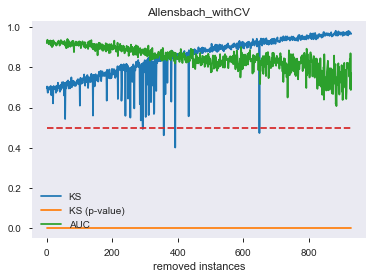

In [11]:
plot_results(score, n, 'Allensbach_withCV')

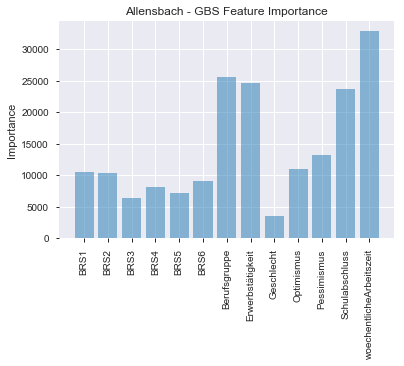

In [12]:
y_pos = np.arange(len(allensbach_columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, allensbach_columns, rotation=90)
plt.ylabel('Importance')
plt.title('Allensbach - GBS Feature Importance')
plt.show()